# Matrix Factorization for Movie Recommendations

In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import chi2_contingency, ttest_ind, ttest_rel, f_oneway
%matplotlib inline
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
rc('pdf', fonttype=42)

# Amazon Electronics


In [2]:
dataset = 'electronics'
ratings = pd.read_csv('../data/raw/df_'+dataset+'.csv', usecols=["user_id", "item_id", "rating", "brand", "category"])
ratings.dropna(subset=["brand", "category"], axis=0, inplace=True)
# ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
ratings.reset_index(inplace=True, drop=True)
ratings


,item_id,user_id,rating,category,brand
0,1,14,4.0,Computers & Accessories,HP
1,1,42,5.0,Computers & Accessories,HP
2,1,75,5.0,Computers & Accessories,HP
3,1,76,5.0,Computers & Accessories,HP
4,1,77,2.0,Computers & Accessories,HP
...,...,...,...,...,...
331115,9320,1157614,1.0,Computers & Accessories,ebasy
331116,9320,1157622,1.0,Computers & Accessories,ebasy
331117,9320,1157625,5.0,Computers & Accessories,ebasy
331118,9478,1157628,1.0,Headphones,Etre Jeune


In [3]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331120 entries, 0 to 331119
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   item_id   331120 non-null  int64  
 1   user_id   331120 non-null  int64  
 2   rating    331120 non-null  float64
 3   category  331120 non-null  object 
 4   brand     331120 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 12.6+ MB


In [4]:
ratings.rating.value_counts()

rating
5.0    191386
4.0     57318
1.0     35521
3.0     26327
2.0     20568
Name: count, dtype: int64

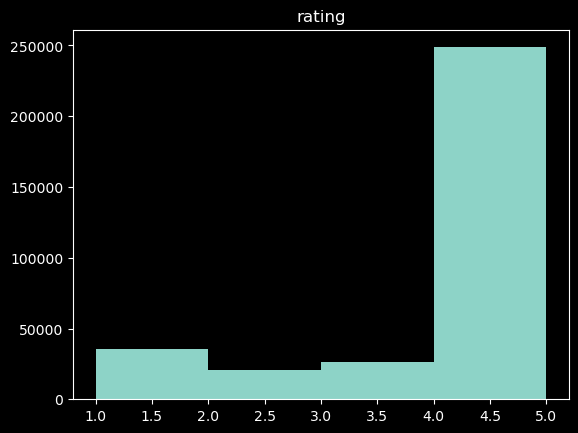

In [5]:
ratings.hist("rating", bins=[1,2,3,4,5], grid=False);

In [6]:
ratings['title'] = ratings['brand'] + ' products in ' + ratings['category']
ratings.drop(columns=["category", "brand"], inplace=True)
ratings

,item_id,user_id,rating,title
0,1,14,4.0,HP products in Computers & Accessories
1,1,42,5.0,HP products in Computers & Accessories
2,1,75,5.0,HP products in Computers & Accessories
3,1,76,5.0,HP products in Computers & Accessories
4,1,77,2.0,HP products in Computers & Accessories
...,...,...,...,...
331115,9320,1157614,1.0,ebasy products in Computers & Accessories
331116,9320,1157622,1.0,ebasy products in Computers & Accessories
331117,9320,1157625,5.0,ebasy products in Computers & Accessories
331118,9478,1157628,1.0,Etre Jeune products in Headphones


# Train Test Split

In [7]:
train, test = train_test_split(ratings, test_size=0.2, random_state=42)
train_ratings = pd.DataFrame(index=ratings["user_id"].unique(), columns=ratings["item_id"].unique())
test_ratings = train_ratings.copy()

In [8]:
for i in range(len(train)):
    train_ratings.loc[train["user_id"].iloc[i], train["item_id"].iloc[i]] = train["rating"].iloc[i]
for i in range(len(test)):
    test_ratings.loc[test["user_id"].iloc[i], test["item_id"].iloc[i]] = test["rating"].iloc[i]

In [9]:
train_ratings

,1,4,5,6,7,9,11,12,13,14,...,9506,9510,9513,9516,9529,9537,9540,9551,9555,9556
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1157614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157622,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1157628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
train_means = np.mean(train_ratings, axis=0)
train_means

1       3.880952
4          3.625
5       3.055556
6           4.25
7       2.612903
          ...   
9537         4.0
9540    4.285714
9551        4.25
9555         5.0
9556         4.5
Length: 2207, dtype: object

In [11]:
train_demeaned = train_ratings.fillna(train_means, axis=0)
train_demeaned = train_demeaned - train_means
train_demeaned = train_demeaned.astype(float)
train_demeaned.isna().sum().sum()

/var/folders/4z/t3p0cxjx63gd2x87gr6ps72w0000gn/T/ipykernel_84960/1110886839.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_demeaned = train_ratings.fillna(train_means, axis=0)


KeyboardInterrupt: 

In [ ]:
from scipy.sparse import dia_matrix, csr_matrix, csc_matrix, coo_matrix, bsr_matrix

train_sparse = bsr_matrix(train_demeaned)
train_sparse

In [ ]:
train_np = train_demeaned.to_numpy()

In [ ]:
train_np

In [ ]:

U, sigma, Vt = svds(train_sparse, k=42)
sigma = np.diag(sigma)
sigma

In [ ]:
scipy.sparse.dia_matrix


In [ ]:
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predictions = pd.DataFrame(predicted_ratings, columns=train_ratings.columns, index=train_ratings.index)
predictions += train_means
predictions = np.clip(predictions, 1, 5)
predictions

In [ ]:
np.std(predictions.iloc[:, 0])

In [ ]:
np.std(predictions.iloc[:, 1])

In [ ]:
train_means

In [ ]:
# Predicted and filter
pred_np = predictions.to_numpy()
train_np = train_ratings.to_numpy()
test_np = test_ratings.to_numpy()

# Filter preds for train
train_pred_np = pred_np[train_ratings.notna()]
train_np = train_np[train_ratings.notna()]

# Filter preds for test
test_pred_np = pred_np[test_ratings.notna()]
test_np = test_np[test_ratings.notna()]

train_pred_np.shape, train_np.shape

In [ ]:
from sklearn.metrics import root_mean_squared_error

print("The training root mean squared error is: " + str(round(root_mean_squared_error(train_np, train_pred_np), 6)))
print("The test root mean squared error is: " + str(round(root_mean_squared_error(test_np, test_pred_np), 6)))

get user row
remove what theyve seen
give them n_recs

In [ ]:
user_predictions = predictions.loc[14, : ].sort_values()

In [ ]:
rated = ratings.loc[ratings["user_id"] == 14, "title"]
not_rated = ratings[~ratings.title.isin(rated)]["title"].drop_duplicates()
not_rated

In [ ]:
recommendations = predictions[predictions.index.isin(not_rated.values)]
recommendations


In [ ]:

= not_rated.sort_values(ascending=False).head(3)
recommendations = recommendations.reset_index()
recommendations


In [ ]:
def where_to_shop(user_id, ratings, predictions, n_recs=3):
    """
    Name: where_to_shop
    Purpose: function that utilizes a partial singular value decomposition of a sparse matrix to recommend content to user
    Inputs:     1. user_id
                2. ratings: DataFrame of item ratings
                3. predictions: DataFrame of predicted ratings by each user_id
                4. n_recs: number of recommendations wanted
    Outputs:  1. DataFrame of recommendations
    Side effects: none
    """
    # filter out movies user has watched
    rated = ratings.loc[ratings["user_id"] == user_id, "item_id"]
    not_rated = ratings[~ratings.index.isin(rated)]

    # sort by rank, return top n_recs recommendations
    recommendations = not_rated.sort_values(ascending=False).head(n_recs)
    recommendations = recommendations.reset_index()

    # rename columns to match function signature
    result = pd. DataFrame ({
    "mean_rating": recommendations[('rating', 'mean' )],
    'Check out..': recommendations['title'],
    'rank': recommendations['rank']
    })

    return result